In [126]:
import numpy as np
import pandas as pd
import os

In [127]:
train = pd.read_csv('train.csv')
train_og = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample.csv.csv')

# Exploratory Data Analysis
First i want to see what the data looks like. After that find any null values and decide how to manage them and also deal with outliers.

In [128]:
train.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,extra,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,1,2023-06-28 17:20:21,2023-06-28 16:34:45,1.0,2.14,1.0,N,120,9,Credit Card,2.5,7.165589,0.0,1.0,20.64,2.5,0.0
1,0,2023-06-29 23:05:01,2023-06-29 22:01:35,1.0,2.70,1.0,N,15,215,Credit Card,3.5,6.067401,0.0,1.0,25.55,2.5,0.0
2,1,2023-06-30 10:19:31,2023-06-30 11:13:10,1.0,1.15,1.0,N,167,223,Credit Card,0.0,4.111547,0.0,1.0,17.64,2.5,0.0
3,0,2023-06-29 13:23:09,2023-06-29 14:20:01,1.0,0.40,1.0,N,128,239,Credit Card,2.5,6.411079,0.0,1.0,12.80,2.5,0.0
4,1,2023-06-29 22:03:32,2023-06-29 22:22:22,3.0,1.10,1.0,N,203,52,Credit Card,1.0,4.769377,0.0,1.0,18.00,2.5,0.0


In [129]:
train.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,extra,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
count,175000.000000,168923.000000,175000.000000,168923.000000,175000.000000,175000.000000,175000.000000,175000.000000,175000.000000,175000.000000,175000.000000,168923.000000,168923.000000
mean,0.728377,1.357678,5.145930,1.518307,132.710349,132.701429,1.932143,6.127497,0.646816,0.979689,29.633901,2.246971,0.158825
std,0.445606,0.891283,394.971052,6.514678,76.148799,76.192493,1.948497,4.610834,2.328274,0.198775,25.425206,0.819216,0.511968
min,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,-7.500000,0.000079,-29.300000,-1.000000,-576.750000,-2.500000,-1.750000
25%,0.000000,1.000000,1.080000,1.000000,67.000000,67.000000,0.000000,3.473321,0.000000,1.000000,16.300000,2.500000,0.000000
50%,1.000000,1.000000,1.840000,1.000000,133.000000,133.000000,1.000000,5.286217,0.000000,1.000000,21.450000,2.500000,0.000000
75%,1.000000,1.000000,3.610000,1.000000,199.000000,199.000000,2.500000,7.502746,0.000000,1.000000,31.800000,2.500000,0.000000
max,2.000000,9.000000,135182.060000,99.000000,264.000000,264.000000,11.750000,484.876151,80.000000,1.000000,587.250000,2.500000,1.750000


In [130]:
train.dtypes

VendorID                   int64
tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count          float64
trip_distance            float64
RatecodeID               float64
store_and_fwd_flag        object
PULocationID               int64
DOLocationID               int64
payment_type              object
extra                    float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
congestion_surcharge     float64
Airport_fee              float64
dtype: object

In [131]:
train.isnull().sum()

VendorID                    0
tpep_pickup_datetime        0
tpep_dropoff_datetime       0
passenger_count          6077
trip_distance               0
RatecodeID               6077
store_and_fwd_flag       6077
PULocationID                0
DOLocationID                0
payment_type                0
extra                       0
tip_amount                  0
tolls_amount                0
improvement_surcharge       0
total_amount                0
congestion_surcharge     6077
Airport_fee              6077
dtype: int64

We can see that store_and_fwd_flag is "object" type and it has missing values. We will see what the values are and how many of them are missing.

In [132]:
train['store_and_fwd_flag'].unique()

array(['N', nan, 'Y'], dtype=object)

We can see that it is actually a string that essentially is a boolean value of true or false. We will convert it to a boolean value.

In [133]:
train['store_and_fwd_flag'] = train['store_and_fwd_flag'].map({'N':False, 'Y':True})
train['store_and_fwd_flag'].unique()

array([False, nan, True], dtype=object)

In [134]:
storenan = train[train['store_and_fwd_flag'].isnull()]
passengernan = train[train['passenger_count'].isnull()]
storenan

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,extra,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
33,1,2023-06-29 23:59:24,2023-06-29 23:10:40,NaN,2.80,NaN,NaN,216,21,Wallet,0.0,6.076642,0.00,1.0,26.93,NaN,NaN
53,1,2023-06-30 02:43:08,2023-06-30 03:44:22,NaN,18.98,NaN,NaN,72,263,Wallet,0.0,11.588252,12.75,1.0,83.24,NaN,NaN
56,1,2023-06-30 22:28:53,2023-06-30 23:33:12,NaN,1.36,NaN,NaN,116,128,Wallet,0.0,4.932110,0.00,1.0,20.69,NaN,NaN
120,0,2023-06-28 22:24:34,2023-06-28 21:57:57,NaN,1.30,NaN,NaN,183,191,Wallet,1.0,5.138688,0.00,1.0,17.25,NaN,NaN
127,0,2023-06-28 21:19:33,2023-06-28 22:56:28,NaN,0.00,NaN,NaN,8,40,Wallet,0.0,1.613173,0.00,1.0,34.11,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174925,1,2023-06-28 20:24:56,2023-06-28 20:10:58,NaN,4.46,NaN,NaN,70,228,Wallet,0.0,0.579162,0.00,1.0,51.06,NaN,NaN
174935,1,2023-06-29 09:07:59,2023-06-29 08:39:05,NaN,2.97,NaN,NaN,187,216,Wallet,0.0,5.306986,0.00,1.0,27.50,NaN,NaN
174983,1,2023-06-30 21:57:30,2023-06-30 20:55:40,NaN,4.22,NaN,NaN,193,108,Wallet,0.0,9.141031,0.00,1.0,34.19,NaN,NaN
174985,1,2023-06-30 08:12:28,2023-06-30 08:36:47,NaN,2.51,NaN,NaN,97,17,Wallet,0.0,4.679583,0.00,1.0,23.44,NaN,NaN


In [135]:
storenan.equals(passengernan)

True

Now this shows us that all rows with nan for store_and_fwd_flag are rows with the other missing values. For the first attempt we will put the mode in all the missing nan values.

In [136]:
train['store_and_fwd_flag'].fillna(train['store_and_fwd_flag'].mode()[0], inplace=True)
train['passenger_count'].fillna(train['passenger_count'].mode()[0], inplace=True)
train['RatecodeID'].fillna(train['RatecodeID'].mode()[0], inplace=True)
train['congestion_surcharge'].fillna(train['congestion_surcharge'].mode()[0], inplace=True)
train['Airport_fee'].fillna(train['Airport_fee'].mode()[0], inplace=True)

In [137]:
train.isnull().sum()

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
extra                    0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
congestion_surcharge     0
Airport_fee              0
dtype: int64

In [138]:
import matplotlib.pyplot as plt
def get_vis():
    # Get the list of numerical columns
    numerical_cols = train.select_dtypes(include=['int64', 'float64']).columns
    if 'tpep_dropoff_datetime' in numerical_cols:
        numerical_cols = numerical_cols.drop('tpep_dropoff_datetime')
    if 'tpep_pickup_datetime' in numerical_cols:
        numerical_cols = numerical_cols.drop('tpep_pickup_datetime')

    # Set the number of columns for subplots
    n_cols = 6

    # Calculate the number of rows needed for subplots
    n_rows = (2 * len(numerical_cols) + n_cols - 1) // n_cols

    # Create a figure and axes with subplots
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 5*n_rows))

    for i, column in enumerate(numerical_cols):
        # Calculate the row and column indices for the original and cleaned datasets
        row_orig = 2 * i // n_cols
        col_orig = 2 * i % n_cols
        row_clean = (2 * i + 1) // n_cols
        col_clean = (2 * i + 1) % n_cols

        # Plot histogram for original dataset
        axes[row_orig, col_orig].hist(train_og[column].dropna(), bins=30, alpha=0.5, color='b', label='Original')
        axes[row_orig, col_orig].set_title(f'{column} (Original)')
        axes[row_orig, col_orig].legend()

        # Plot histogram for cleaned dataset
        axes[row_clean, col_clean].hist(train[column].dropna(), bins=30, alpha=0.5, color='r', label='Cleaned')
        axes[row_clean, col_clean].set_title(f'{column} (Cleaned)')
        axes[row_clean, col_clean].legend()

    # Remove empty subplots
    if (2 * len(numerical_cols)) % n_cols:
        for j in range((2 * len(numerical_cols)) % n_cols, n_cols):
            fig.delaxes(axes[n_rows-1, j])

    plt.show()

# get_vis()

### This is visually show that the dataset isn't changed drastically after adding the mode in place of the missing values.
Now we will perform one hot encoding to the "object" type columns.

In [139]:
# we have to do encoding to these columns tpep_pickup_datetime, tpep_dropoff_datetime, store_and_fwd_flag, payment_type

# this is just for cleanliness
train['tpep_pickup_datetime'] = pd.to_datetime(train['tpep_pickup_datetime'])
train['tpep_dropoff_datetime'] = pd.to_datetime(train['tpep_dropoff_datetime'])

# one hot encoding
train_encoded = pd.get_dummies(train, columns=['store_and_fwd_flag', 'payment_type'])

# now we will convert the datetime columns to unix timestamp
train_encoded['tpep_pickup_datetime'] = train_encoded['tpep_pickup_datetime'].astype(np.int64) // 10**9
train_encoded['tpep_dropoff_datetime'] = train_encoded['tpep_dropoff_datetime'].astype(np.int64) // 10**9


train = train_encoded
train_encoded.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,extra,tip_amount,...,total_amount,congestion_surcharge,Airport_fee,store_and_fwd_flag_False,store_and_fwd_flag_True,payment_type_Cash,payment_type_Credit Card,payment_type_UPI,payment_type_Wallet,payment_type_unknown
0,1,1687972821,1687970085,1.0,2.14,1.0,120,9,2.5,7.165589,...,20.64,2.5,0.0,True,False,False,True,False,False,False
1,0,1688079901,1688076095,1.0,2.70,1.0,15,215,3.5,6.067401,...,25.55,2.5,0.0,True,False,False,True,False,False,False
2,1,1688120371,1688123590,1.0,1.15,1.0,167,223,0.0,4.111547,...,17.64,2.5,0.0,True,False,False,True,False,False,False
3,0,1688044989,1688048401,1.0,0.40,1.0,128,239,2.5,6.411079,...,12.80,2.5,0.0,True,False,False,True,False,False,False
4,1,1688076212,1688077342,3.0,1.10,1.0,203,52,1.0,4.769377,...,18.00,2.5,0.0,True,False,False,True,False,False,False


In [140]:
# Convert boolean columns to integer
bool_cols = ['store_and_fwd_flag_False', 'store_and_fwd_flag_True', 'payment_type_Cash', 'payment_type_Credit Card', 'payment_type_UPI', 'payment_type_Wallet', 'payment_type_unknown']
train[bool_cols] = train[bool_cols].astype(int)

#### Now that we have the data in a format that we can use, we will start to explore the data and removing outliers.

In [141]:
train.dtypes

VendorID                      int64
tpep_pickup_datetime          int64
tpep_dropoff_datetime         int64
passenger_count             float64
trip_distance               float64
RatecodeID                  float64
PULocationID                  int64
DOLocationID                  int64
extra                       float64
tip_amount                  float64
tolls_amount                float64
improvement_surcharge       float64
total_amount                float64
congestion_surcharge        float64
Airport_fee                 float64
store_and_fwd_flag_False      int32
store_and_fwd_flag_True       int32
payment_type_Cash             int32
payment_type_Credit Card      int32
payment_type_UPI              int32
payment_type_Wallet           int32
payment_type_unknown          int32
dtype: object

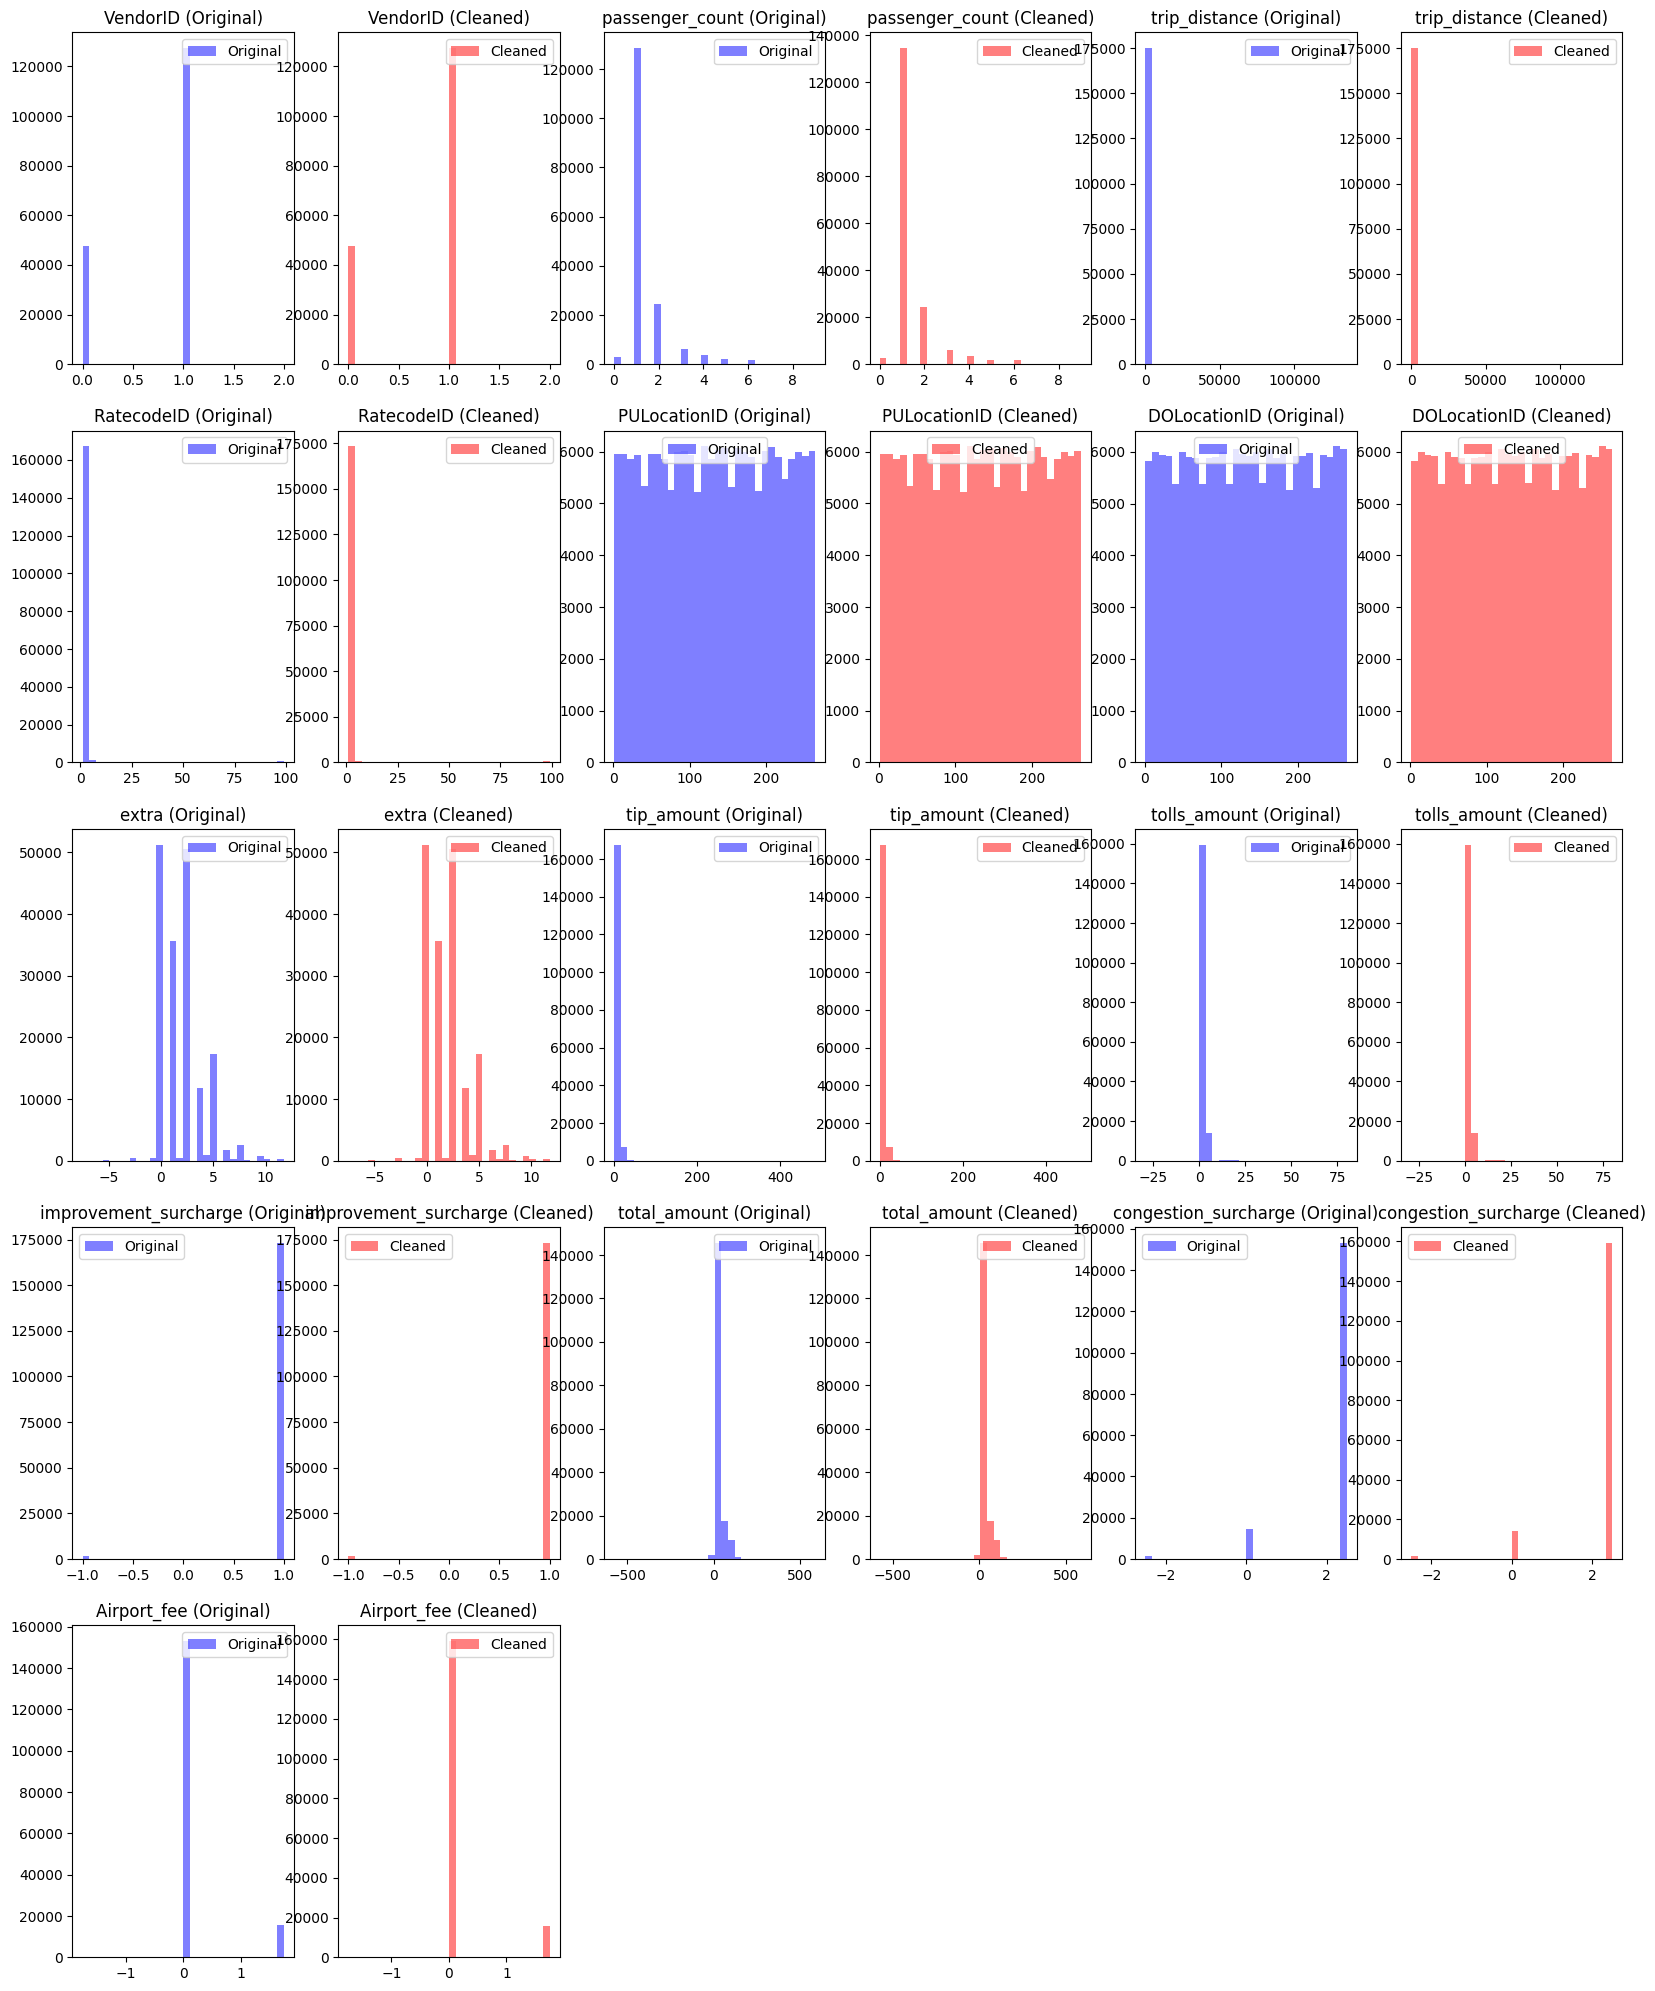

In [142]:
get_vis()

Now we will make box plots to visualize outliers
###### We are not visualizing the categorical values.

In [143]:
# box plots
def get_vis_box():
    # Get the list of numerical columns
    numerical_cols = train.select_dtypes(include=['int64', 'float64']).columns
    if 'tpep_dropoff_datetime' in numerical_cols:
        numerical_cols = numerical_cols.drop('tpep_dropoff_datetime')
    if 'tpep_pickup_datetime' in numerical_cols:
        numerical_cols = numerical_cols.drop('tpep_pickup_datetime')

    # Set the number of columns for subplots
    n_cols = 6

    # Calculate the number of rows needed for subplots
    n_rows = len(numerical_cols) // n_cols
    n_rows += len(numerical_cols) % n_cols

    # Create a figure and axes with subplots
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 5*n_rows))

    for i, column in enumerate(numerical_cols):
        # Calculate the row and column indices
        row = i // n_cols
        col = i % n_cols

        # Plot boxplot
        axes[row, col].boxplot(train[column].dropna())
        axes[row, col].set_title(f'{column}')

    # Remove empty subplots
    if len(numerical_cols) % n_cols:
        for j in range(len(numerical_cols) % n_cols, n_cols):
            fig.delaxes(axes[n_rows-1, j])

    plt.tight_layout()
    plt.show()

# get_vis_box()

### Now we will go column by column
Vendor ID is not something we should thing about as it is an ID.
Let's see passenger_count more carefully.

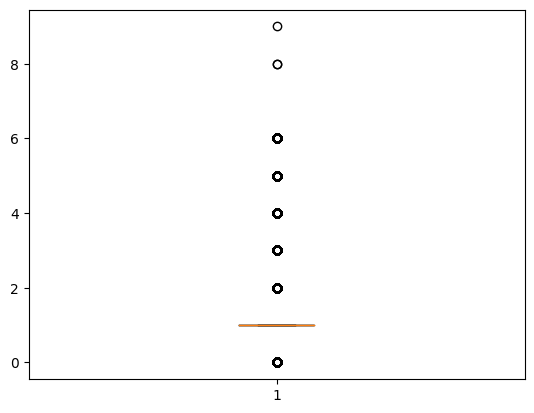

passenger_count
1.0    134611
2.0     24316
3.0      6018
4.0      3668
0.0      2818
5.0      1970
6.0      1596
8.0         2
9.0         1
Name: count, dtype: int64

In [144]:
# visualize outlier in passenger_count
# coloured box plot
plt.boxplot(train['passenger_count'])
plt.show()
# count of each value in passenger_count
train['passenger_count'].value_counts()

We can see that only 8.0 and 9.0 are the outliers here. The rest have significant amount of data. We will remove the outliers.

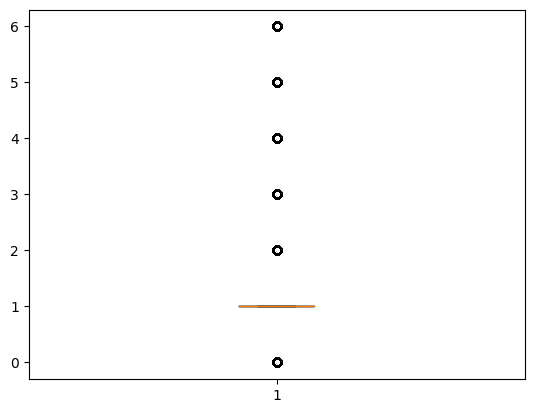

passenger_count
1.0    134611
2.0     24316
3.0      6018
4.0      3668
0.0      2818
5.0      1970
6.0      1596
Name: count, dtype: int64

In [145]:
train.drop(train[train['passenger_count'] > 7].index, inplace=True)
plt.boxplot(train['passenger_count'])
plt.show()
train['passenger_count'].value_counts()

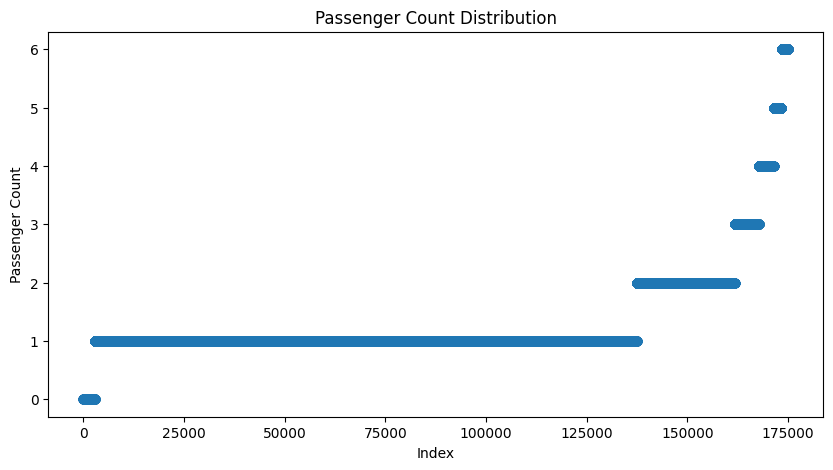

In [146]:
plt.figure(figsize=(10, 5))
plt.scatter(range(train.shape[0]), np.sort(train['passenger_count'].values))
plt.xlabel('Index')
plt.ylabel('Passenger Count')
plt.title('Passenger Count Distribution')
plt.show()

#### While the box plot makes it look like there are a lot of outliers, the scatter plot shows that it is not the case.
Now we repeat for all the other columns.

In [37]:
import sklearn as sk
import xgboost as xgb
import imblearn as imb
import scipy as sp
import pickle as pkl
import regex as re
import seaborn as sns
import matplotlib as mpl
import lightgbm as lgb